In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from utils import *

In [2]:
df = pd.read_csv("data/topic_modeling_task_sample_trainPart.csv")
df.rename(columns={"ACTION_ITEM_RESULT_PRODUCT_NAME": "category"}, inplace=True)
df

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,category
0,3,7,"5,01000641613474E+017",добрый_день. это клиентский_менеджер виктория ...,2021-02-16,Бизнес-карта
1,6,15,"5,01001121614156E+017",добрый_день. меня зовут клиентский_менеджер_сб...,2021-02-24,Зарплатные проекты
2,10,28,"5,01001811614178E+017",добрый_день. меня зовут сбербанк блок сбер биз...,2021-02-24,Зарплатные проекты
3,14,35,"5,01002531614256E+017",еще раз добрый_день клиентский_менеджер удобно...,2021-02-25,Бизнес-карта
4,23,68,"5,01005041613457E+017",добрый_день. это сбербанк блок сбер бизнес кли...,2021-02-16,Зарплатные проекты
...,...,...,...,...,...,...
42760,138892,350772,"5,01034111613466E+017",добрый_день. это ваш персональный_менеджер_сбе...,2021-02-16,Зарплатные проекты
42761,138893,350773,"5,01034111613466E+017",здравствуйте. как я могу к вам обращаться. на ...,2021-02-16,Зарплатные проекты
42762,138898,350793,"5,01035251614262E+017",добрый_день. персональный_менеджер_сбербанк ва...,2021-02-25,Открытие банковского счета
42763,138899,350797,"5,01035571614254E+017",добрый_день. вас персональный_менеджер сбер би...,2021-02-25,Бизнес-карта


### 1. Удаление дубликатов и примеров, содержащих разные метки для одинаковых текстов

In [3]:
df = df.drop_duplicates(subset=["text_employer", "category"], keep="first")

mask = df.groupby("text_employer")["category"].transform("nunique").gt(1)
df = df[~mask]
df = df.reset_index(drop=True)
df

,Unnamed: 0.1,Unnamed: 0,ucid,text_employer,date,category
0,3,7,"5,01000641613474E+017",добрый_день. это клиентский_менеджер виктория ...,2021-02-16,Бизнес-карта
1,6,15,"5,01001121614156E+017",добрый_день. меня зовут клиентский_менеджер_сб...,2021-02-24,Зарплатные проекты
2,10,28,"5,01001811614178E+017",добрый_день. меня зовут сбербанк блок сбер биз...,2021-02-24,Зарплатные проекты
3,14,35,"5,01002531614256E+017",еще раз добрый_день клиентский_менеджер удобно...,2021-02-25,Бизнес-карта
4,23,68,"5,01005041613457E+017",добрый_день. это сбербанк блок сбер бизнес кли...,2021-02-16,Зарплатные проекты
...,...,...,...,...,...,...
42132,138892,350772,"5,01034111613466E+017",добрый_день. это ваш персональный_менеджер_сбе...,2021-02-16,Зарплатные проекты
42133,138893,350773,"5,01034111613466E+017",здравствуйте. как я могу к вам обращаться. на ...,2021-02-16,Зарплатные проекты
42134,138898,350793,"5,01035251614262E+017",добрый_день. персональный_менеджер_сбербанк ва...,2021-02-25,Открытие банковского счета
42135,138899,350797,"5,01035571614254E+017",добрый_день. вас персональный_менеджер сбер би...,2021-02-25,Бизнес-карта


### 2. Распределение примеров по классам

In [4]:
df["category"].value_counts()

category
Бизнес-карта                  19128
Зарплатные проекты            12243
Открытие банковского счета     6524
Эквайринг                      4242
Name: count, dtype: int64

### 3. Распределние данных по количеству реплик

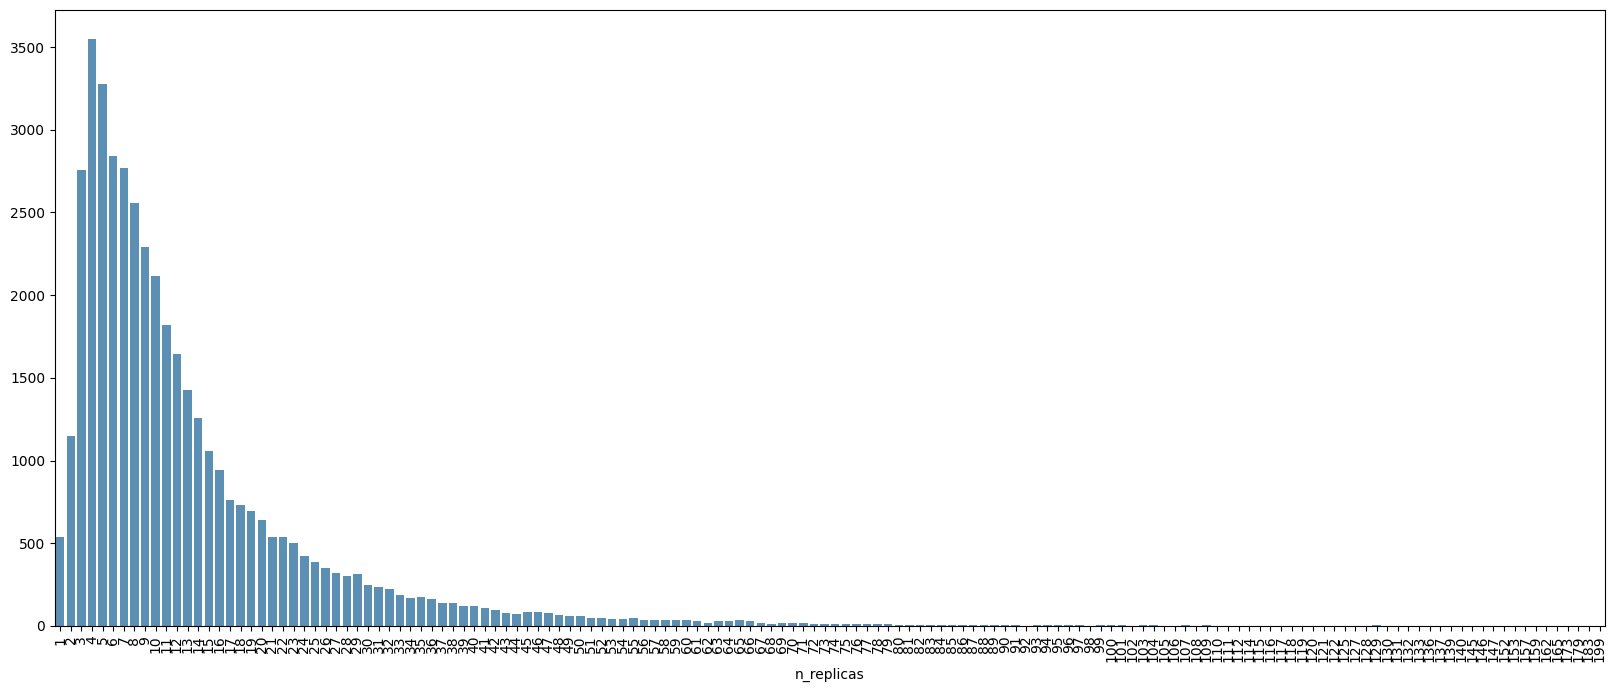

In [5]:
def get_number_of_replicas(text):
    return len(text.split("."))


df["n_replicas"] = df["text_employer"].apply(get_number_of_replicas)

n_replicas_count = df["n_replicas"].value_counts()
plt.figure(figsize=(20, 8))
sns.barplot(x=n_replicas_count.index, y=n_replicas_count.values, alpha=0.8)
plt.xticks(rotation=90)
plt.show()

Я долго думал, как это можно использовать, но не придумал. Идея добавить дополнительную фичу мне кажется нерабочей.

### 4. Упрощение: агрегация нескольких текстов одного обращения в одно (как для обучения так и для теста)

Возможно не самая удачная идея, которая сильно нагромождает отдельные диалгоги. Другой подход — рассматривать все диалоги как отдельные, тогда необходимо решить, как программа будет работать на тесте: здесь я вижу 2 пути:
1. Предсказывать метки отдельно для каждого диалога и:
* оставить предсказания как есть
* как-то их сопоставлять (например взять argmax суммы полученных векторов, если модель выдает вероятности, с SVM - сложнее)
2. Предсказывать метку для объединенного текста, но тогда и обучаться логичнее на таких же данных

**Далее** я объединяю диалоги одного обращения в один как в трейне, так и в тесте

In [6]:
sum(df["ucid"].value_counts() > 1)  # количество обращений с несоклькими диалогами

1722

In [7]:
# df_grouped = df.groupby('ucid')['text_employer'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped = (
    df.groupby("ucid")
    .agg({"text_employer": " ".join, "category": "first"})
    .reset_index()
)
df_grouped

,ucid,text_employer,category
0,"1,11010014416136E+019",здравствуйте клиентский_менеджер я ну как бы. ...,Эквайринг
1,"1,11010033816134E+019",понятно мне не продаж к вам как по попрощаться...,Зарплатные проекты
2,"1,11010037916137E+019",добрый_день сбербанк слушаю вас. через личный_...,Бизнес-карта
3,"1,11010044816145E+019",меня зовут здравствуйте. как я могу к вам обра...,Эквайринг
4,"1,11010047416135E+019",добрый_день меня зовут как вас зовут. пожалуйс...,Эквайринг
...,...,...,...
40132,"5,01154221613738E+017",добрый_день это ваш персональный_менеджер коле...,Бизнес-карта
40133,"5,01154221613743E+017",добрый вечер. меня зовут я представляю сбер би...,Зарплатные проекты
40134,"5,01154231614231E+017",добрый_день это это клиентский_менеджер вводим...,Зарплатные проекты
40135,"5,01154231614237E+017",добрый_день. это ваш персональный_менеджер_сбе...,Бизнес-карта


### 5. Как связаны классы с парами слов, записанными через нижнее подчеркивание

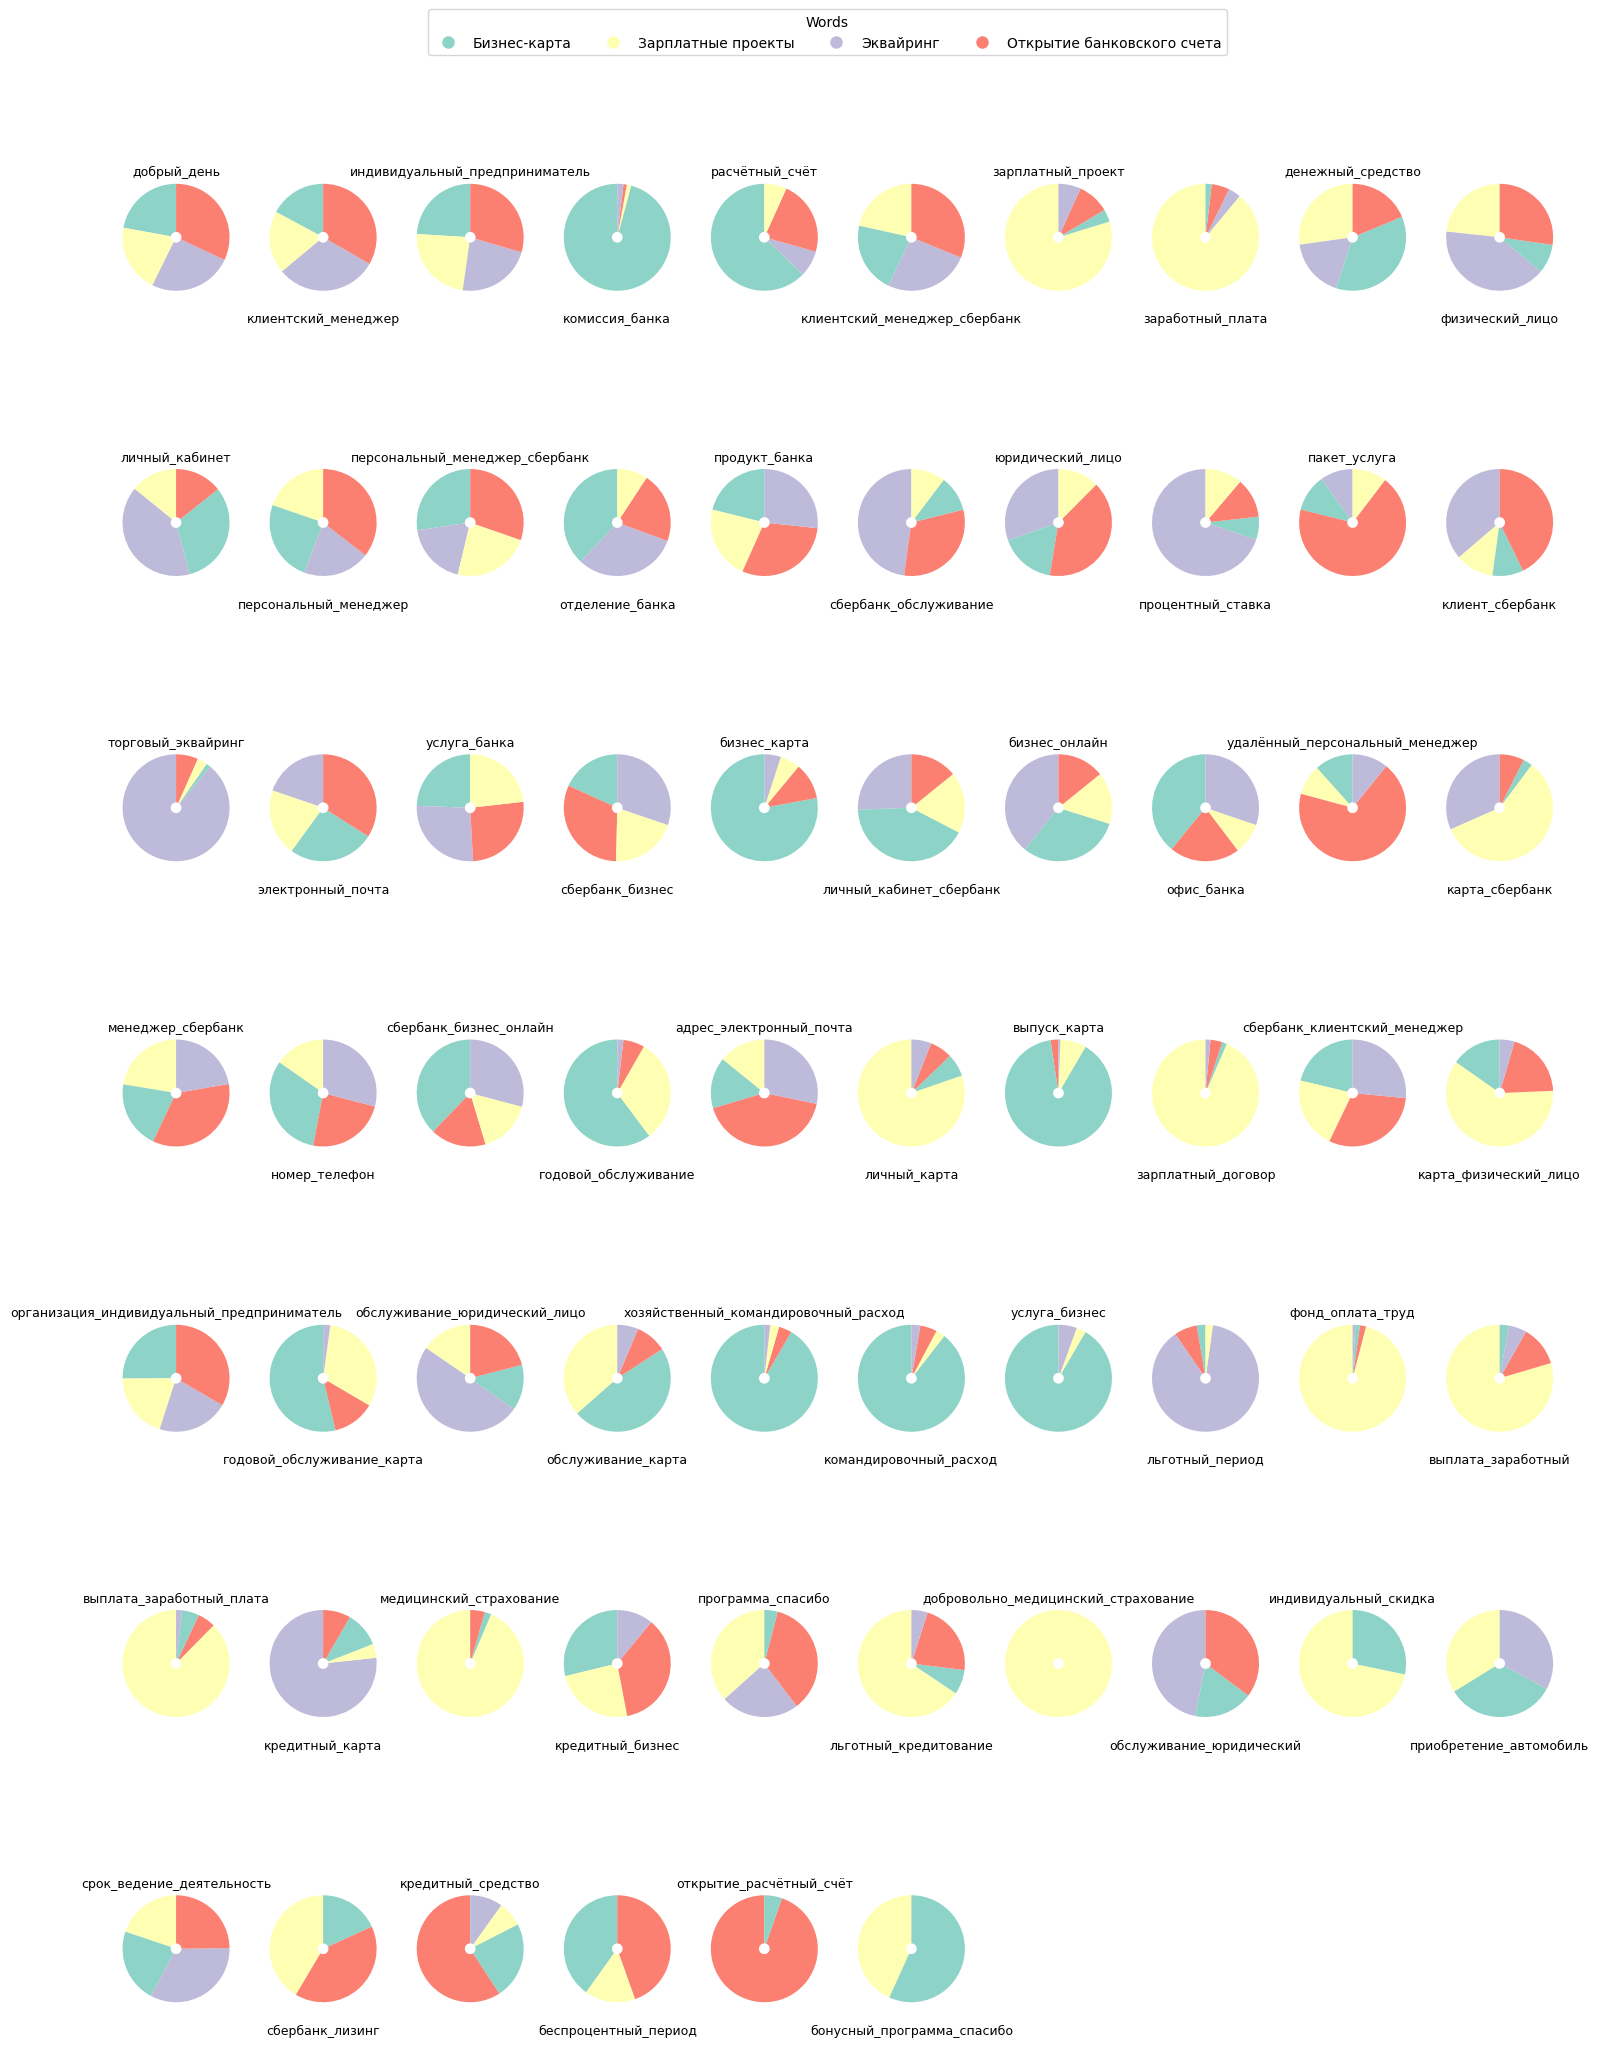

In [8]:
def get_ul_seq(input_string):
    pattern = r"\w+_\w+"
    matches = re.findall(pattern, input_string)
    return matches


plot_relative_freq_per_category(get_relative_freq_per_category(df, get_ul_seq))

Очевидно, что такие фразы-последовательности (не все) влияют на распредление по классам. Их однозначно стоит оставить.

### Разбиение данных на условно тренировочное и тестовое

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
y = df_grouped["category"].values

df_train_ind, df_test_ind, y_train, y_test = train_test_split(
    df_grouped.index, y, test_size=0.25, random_state=42
)

df_train = df_grouped.iloc[df_train_ind]
df_test = df_grouped.iloc[df_test_ind]

In [11]:
# необходимо проверить сохранение распределения меток на тестовом множестве
df_test["category"].value_counts()

category
Бизнес-карта                  4572
Зарплатные проекты            2939
Открытие банковского счета    1530
Эквайринг                      994
Name: count, dtype: int64

In [12]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [13]:
df_train.to_csv("data/train.csv")
df_test.to_csv("data/test.csv")